In [1]:
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import expon, truncexpon, truncnorm, nbinom, norm
import pandas as pd
import time
import torch
from torch import nn
from torch import distributions
from torch import rand
from torch import autograd
from torch import optim

In [2]:
np.random.seed(seed=101)
torch.manual_seed(101)
torch.use_deterministic_algorithms(True)
dtype = torch.float64
device = torch.device("cpu")

In [3]:
data = pd.read_csv('covid19model.csv')

In [4]:
toy_data = pd.read_csv('toy_data.csv')
toy_data

,Unnamed: 0,0
0,0,9.319691e-16
1,1,2.800236e-02
2,2,6.963707e-02
3,3,1.213362e-01
4,4,1.795116e-01
...,...,...
402,402,4.089112e-03
403,403,3.417061e-03
404,404,2.855353e-03
405,405,2.385894e-03


    # Toy Data
    tau = torch.tensor(33) # bij_transform(tau_prime, lower=0, upper=200)
    y = torch.distributions.exponential.Exponential(1 / tau).rsample()
    R0 = torch.tensor(3.6) # bij_transform(R0_prime, lower=2, upper=5)
    phi = torch.tensor(25) # bij_transform(phi_prime, lower=1, upper=50)
    alpha = torch.tensor(0.01) # bij_transform(alpha_prime, lower=0, upper=0.05)
    sigma = torch.tensor(0.1) #bij_transform(sigma_prime, lower=0.0001, upper=0.5)

# Initialization

In [5]:
cero = torch.tensor(0., requires_grad=False, device=device, dtype=dtype)
num_impute = 6
observed_daily_hospit = torch.tensor(toy_data['0'].round(), requires_grad=False, device=device, dtype=dtype)
#observed_daily_hospit = torch.tensor(data.hospit, requires_grad=False, device=device, dtype=dtype)
pi = torch.tensor(data.delay_distr, requires_grad=False, device=device, dtype=dtype)
serial_interval = torch.tensor(data.serial_interval, requires_grad=False, device=device, dtype=dtype)
population = torch.tensor(5793636, requires_grad=False, device=device, dtype=dtype)
num_observations = len(observed_daily_hospit)

## Initialize latent variables/parameters

In [6]:
tau_prime = torch.tensor(np.random.exponential(1 / 0.03), requires_grad=True, device=device, dtype=dtype)
phi_prime = torch.tensor(truncnorm.rvs((0 - 25) / 10, (np.inf - 25) / 10, loc=25, scale=10), requires_grad=True,
                         device=device,
                         dtype=dtype)  # has to be positive, between 0-50 --> uniform # dispersion (shape) parameter for observations
R0_prime = torch.tensor(truncnorm.rvs((2 - 3.6) / 0.8, (5 - 3.6) / 0.8, loc=3.6, scale=0.8), requires_grad=True,
                        device=device,
                        dtype=dtype)  # probably gamma or inverse gamma distribution (compare to truncated normal) # initial reproduction number
alpha_prime = torch.tensor(
    truncnorm.rvs((0 - 1 / 100) / 1 / 100, (5 / 100 - 1 / 100) / 1 / 100, loc=1 / 100, scale=1 / 100),
    requires_grad=True, device=device,
    dtype=dtype)  # uniform distribution between (0-5%) # probability to get hospitalized
sigma_prime = torch.tensor(truncnorm.rvs((0 - 0.1) / 0.3, (0.5 - 0.1) / 0.3, loc=0.1, scale=0.3), requires_grad=True,
                           device=device,
                           dtype=dtype)  # positive, tricky, gamma or inverse gamma, log normal  --> try something out, large sigma--> prone to overfitting # standart deviation of random walk step

epsilon_t = torch.zeros(num_observations, device=device)
epsilon_t[0] = torch.distributions.Normal(cero, sigma_prime.detach()).rsample()
for t in range(1, num_observations):
    epsilon_t[t] = torch.distributions.Normal(epsilon_t[t - 1].detach(), sigma_prime.detach()).rsample()
epsilon_t.requires_grad_(True)


tensor([-0.4062, -0.6443, -0.7379, -0.5224, -1.0346, -0.8584, -0.9320, -1.0597,
        -1.2271, -2.1625, -1.9980, -1.9351, -2.5766, -2.6399, -2.8520, -2.3127,
        -2.2400, -2.1588, -1.6862, -1.7545, -2.1455, -2.1636, -2.2423, -1.9797,
        -1.7461, -1.8958, -2.0178, -1.7697, -1.1899, -1.5608, -1.2986, -0.9878,
        -1.1975, -0.8651, -1.3561, -1.3298, -1.3777, -1.6734, -1.5581, -1.3892,
        -0.9920, -1.1048, -1.2804, -1.7002, -1.6482, -1.9254, -1.9525, -1.6132,
        -1.9811, -1.7413, -1.5891, -1.5620, -1.2712, -1.5568, -1.1379, -1.0850,
        -1.0561, -0.6375, -0.5553, -0.4397, -0.1980, -0.2442, -0.0438,  0.0886,
        -0.0346,  0.0927,  0.2458, -0.2554, -0.6296, -1.1790, -1.6244, -1.6822,
        -1.5316, -1.8503, -1.9239, -2.1913, -2.6200, -2.6891, -2.6408, -2.6501,
        -2.7506, -3.0649, -3.4478, -3.4980, -4.0263, -4.1605, -4.3302, -4.1965,
        -4.3513, -4.5640, -4.2001, -4.0767, -4.0118, -4.0224, -3.5900, -3.1960,
        -3.5165, -3.0897, -2.7679, -2.05

# Define Forward Pass

In [7]:
def bij_transform(prime, lower, upper):
    # Recieves a value in [-inf, inf] and returns value in [low, upper]
    bij = 1 / (1 + torch.exp(-prime))
    scale = upper - lower
    return scale * bij + lower

def bij_transform_inf(prime):
    return torch.exp(prime)

In [8]:
def calc_prior_loss(tau, phi, R0, alpha, sigma):
    # log likelihood wrt. our prior ("regularisation")
    # ll stands for log-likelihood
    ll = torch.tensor(0.0, device=device)

    ll += (tau - (1 / 0.03)) ** 2 * 1e-1

    ll += (phi - 25) ** 2 * 1e0

    ll += (R0 - 3.6) ** 2 * 1e3

    ll += (alpha - 0.01) ** 2 * 1e6

    ll += (sigma - 0.1) ** 2 * 1e4

    return ll

In [9]:
def seed_init_infect(y):
    # Initialize newly_infected, cumulative_infected, St
    newly_infected = torch.zeros(num_observations, device=device, dtype=dtype)  # number of newly infected
    cumulative_infected = torch.zeros(num_observations, device=device)  # cumulative number of infected

    St = torch.zeros(num_observations, device=device)  # fraction of susceptible population
    # seed initial infection / impute first num_impute days
    newly_infected[0:num_impute] = y.clone()
    cumulative_infected[0] = 0.
    cumulative_infected[1:num_impute] = torch.cumsum(newly_infected[0:num_impute - 1].clone(), dim=0)
    St[0:num_impute] = torch.tensor([torch.maximum(population.clone() - x, torch.tensor(0)) / population for x in
                                     cumulative_infected[0:num_impute].clone()])
    return newly_infected, cumulative_infected, St


In [10]:
def calc_Rt(R0, epsilon_t, sigma, ll):
    # Initialize eta_t
    eta_t = torch.zeros(num_observations, device=device)  # transformed reproduction number
    # calculate Rt: the basic reproduction number
    # basic reproduction number as a latent random walk
    beta_0 = torch.log(R0)
    eta_t[0] = beta_0

    #for t in range(1, num_observations):
    #    dist_epsilon_t = torch.distributions.Normal(epsilon_t[t - 1], sigma)
    #    ll += dist_epsilon_t.log_prob(epsilon_t[t])

    loc = epsilon_t[:-1].clone()
    scale = sigma * torch.ones(num_observations-1)
    mvn = distributions.multivariate_normal.MultivariateNormal(loc, scale_tril=torch.diag(scale))
    ll += mvn.log_prob(epsilon_t[1:].clone())

    eta_t[1:num_observations] = beta_0 + epsilon_t[0:num_observations - 1].clone()
    Rt = torch.exp(eta_t)
    ll = ll * (-1)
    return Rt, ll


In [11]:
def calc_infections(cumulative_infected, newly_infected, St, Rt):
    # Initialize effectively_infectious
    effectively_infectious = torch.zeros(num_observations, device=device)  # effective number of infectious individuals

    # calculate infections
    for t in range(num_impute, num_observations):
        # Update cumulative newly_infected
        cumulative_infected[t] = cumulative_infected[t - 1].clone() + newly_infected[t - 1].clone()
        # Adjusts for portion of pop that are susceptible
        St[t] = torch.maximum(population.clone() - cumulative_infected[t].clone(), cero) / population.clone()
        # effective number of infectous individuals
        ni_temp = newly_infected[:t].view(1, 1, -1).clone()
        si_temp = torch.flip(serial_interval, (0,))[-t:].view(1, 1, -1)
        effectively_infectious[t] = torch.nn.functional.conv1d(ni_temp, si_temp)

        newly_infected[t] = St[t].clone() * Rt[t].clone() * effectively_infectious[t].clone()
    return newly_infected


In [12]:
def calc_hospit(newly_infected, alpha):
    # Initialize expected_daily_hospit
    expected_daily_hospit = torch.zeros(num_observations, device=device)  # expected number of daily hospitalizations

    # calculate expected number of hospitalizations
    expected_daily_hospit[0] = (1e-15) * newly_infected[0].clone()
    for t in range(1, num_observations):
        ni_temp = newly_infected[:t].view(1, 1, -1)
        pi_temp = torch.flip(pi, (0,))[-t - 1:-1].view(1, 1, -1)
        expected_daily_hospit[t] = torch.nn.functional.conv1d(ni_temp, pi_temp)
    expected_daily_hospit = alpha * expected_daily_hospit
    return expected_daily_hospit


In [13]:
def compare_results(expected_daily_hospit, phi, ll):
    # compare observed hospitalizations to model results
    # likelihood of the data wrt. to the model

    for i in range(0, num_observations):
        p = 1 / (1 + expected_daily_hospit[i] / phi)
        if p == 1:
            p = p.clone() - torch.tensor(2.225e-5)
        if p < 2.225e-5:
            p = p.clone() + torch.tensor(2.225e-5)
        dist = torch.distributions.negative_binomial.NegativeBinomial(phi, p - torch.tensor(2.225e-5))
        ll += dist.log_prob(observed_daily_hospit[i])
    ll = ll * (-1)
    return ll


In [14]:
def forward_pass():
    # Initialize y
    tau = bij_transform(tau_prime, lower=0, upper=200)
    y = torch.distributions.exponential.Exponential(1 / tau).rsample()
    R0 = bij_transform(R0_prime, lower=2, upper=5)
    phi = bij_transform(phi_prime, lower=1, upper=50)
    alpha = bij_transform(alpha_prime, lower=0, upper=0.05)
    sigma = bij_transform(sigma_prime, lower=0.0001, upper=0.5)


    # Calculate prior loss
    ll_prior = calc_prior_loss(tau, phi, R0, alpha, sigma)

    # Seed initial infections
    newly_infected, cumulative_infected, St = seed_init_infect(y)

    # Calculate Rt & random walk loss
    Rt, ll_rw = calc_Rt(R0, epsilon_t, sigma, torch.tensor(0.0, device=device)) ##ll

    # Calculate infections
    newly_infected = calc_infections(cumulative_infected, newly_infected, St, Rt)

    # Calculate expected hospitalizations
    expected_daily_hospit = calc_hospit(newly_infected, alpha)

    # Compare observed hospitalizations to model results
    ll_comp = compare_results(expected_daily_hospit, phi, torch.tensor(0.0, device=device)) ##ll

    return expected_daily_hospit, Rt, ll_prior, ll_rw, ll_comp, tau, R0, phi, alpha, sigma


# Optimization


Prior Loss:5236.498046875  Random Walk Loss:64.99032592773438 Comparison Loss:265928.1875 


Time Step: 0 || Loss: 271229.6875 || Learning Rate: 0.0001

R0:4.721550867919079  grad:-39321.0424627867
alpha:0.02512499717849155  grad:20877.926429316336
phi:49.99999999989285  grad:9.152030416774965e-08
sigma:0.2863002827801241  grad:458.69091435087074
epsilon_t.mean:-0.37735244631767273  grad.mean:-1831.8409423828125
tau:199.9999999939194  grad:-1.7853555612871807e-07

This Run:  0.7969510555267334 seconds


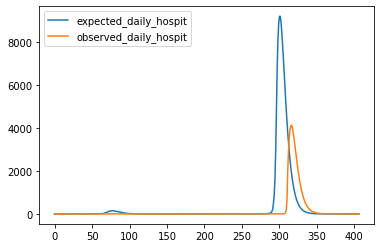

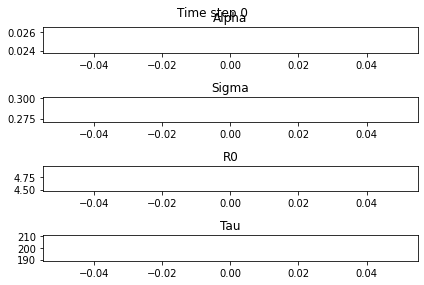


Prior Loss:5636.986328125  Random Walk Loss:78.121337890625 Comparison Loss:175019.296875 


Time Step: 10 || Loss: 180734.40625 || Learning Rate: 9.890564689047751e-05

R0:4.9953889205087805  grad:-180.8832981344632
alpha:0.0004829853923959975  grad:5417.7672818362225
phi:49.99999999989285  grad:3.2446283028664736e-07
sigma:0.24018714804766567  grad:265.56111632373035
epsilon_t.mean:-0.37652820348739624  grad.mean:-516.4660034179688
tau:199.9999999939194  grad:-9.499436770770227e-08

This Run:  0.4706888198852539 seconds


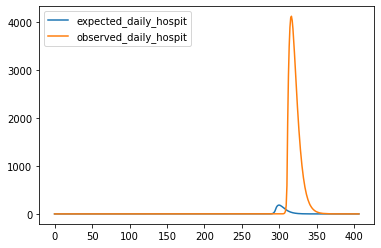


Prior Loss:5579.3486328125  Random Walk Loss:101.56201171875 Comparison Loss:155043.25 


Time Step: 20 || Loss: 160724.15625 || Learning Rate: 9.58842233180029e-05

R0:4.996075015416823  grad:-217.26670208168164
alpha:0.00044051848166190186  grad:-211.1176088818646
phi:49.99999999989285  grad:3.0656137405014654e-07
sigma:0.21668824595858535  grad:120.63965823643366
epsilon_t.mean:-0.3760319650173187  grad.mean:-714.6654052734375
tau:199.9999999939194  grad:-1.034441145553766e-07

This Run:  0.4542961120605469 seconds


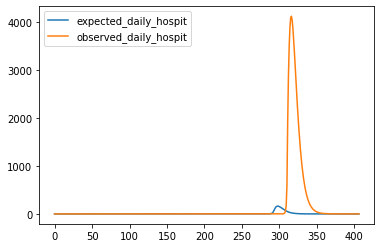


Prior Loss:5563.87109375  Random Walk Loss:116.69195556640625 Comparison Loss:147600.390625 


Time Step: 30 || Loss: 153280.953125 || Learning Rate: 9.111072194465956e-05

R0:4.996690530085175  grad:-63.085767934836255
alpha:0.00021859880491960495  grad:-4965.9465943418345
phi:49.99999999989285  grad:3.147143621195168e-07
sigma:0.20708537867577131  grad:49.02928244726189
epsilon_t.mean:-0.3754219114780426  grad.mean:-268.5768127441406
tau:199.9999999939194  grad:2.0120744673730622e-07

This Run:  0.45267581939697266 seconds


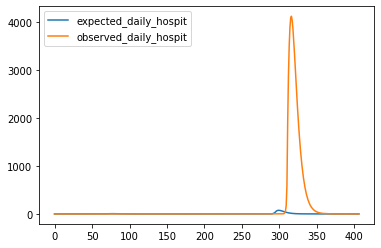


Prior Loss:5552.58349609375  Random Walk Loss:123.58038330078125 Comparison Loss:170766.890625 


Time Step: 40 || Loss: 176443.0625 || Learning Rate: 8.485537498917492e-05

R0:4.997054613163062  grad:-192.69166324012096
alpha:0.00046167834882344976  grad:3781.330320059256
phi:49.99999999989285  grad:3.2315108264856046e-07
sigma:0.2034718370026059  grad:19.683984047928718
epsilon_t.mean:-0.3749349117279053  grad.mean:-838.3255004882812
tau:199.9999999939194  grad:-1.6886848471338847e-07

This Run:  0.44665956497192383 seconds


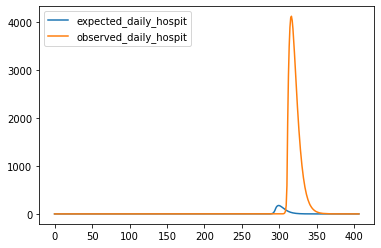


Prior Loss:5551.41748046875  Random Walk Loss:126.5423583984375 Comparison Loss:179923.53125 


Time Step: 50 || Loss: 185601.484375 || Learning Rate: 7.74583094428763e-05

R0:4.99737325965907  grad:-138.11920062053454
alpha:0.00042430350590100333  grad:5648.938792270321
phi:49.99999999989285  grad:3.372163285927262e-07
sigma:0.20212444842400684  grad:8.127594163340525
epsilon_t.mean:-0.37440332770347595  grad.mean:-680.5121459960938
tau:199.9999999939194  grad:-1.1616193700351909e-07

This Run:  0.4532589912414551 seconds


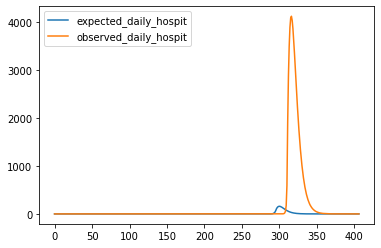


Prior Loss:5550.3623046875  Random Walk Loss:127.86358642578125 Comparison Loss:157120.125 


Time Step: 60 || Loss: 162798.34375 || Learning Rate: 6.929895628442746e-05

R0:4.997597595138745  grad:-139.5381226458931
alpha:0.00045783724297296445  grad:305.1488872878861
phi:49.99999999989285  grad:3.0868415363804563e-07
sigma:0.20161345618321183  grad:3.486935715152686
epsilon_t.mean:-0.3739427328109741  grad.mean:-748.09765625
tau:199.9999999939194  grad:-1.25748246879758e-07

This Run:  0.44818711280822754 seconds


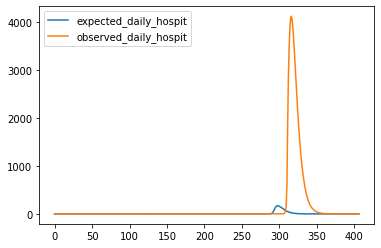


Prior Loss:5551.91064453125  Random Walk Loss:128.55438232421875 Comparison Loss:154233.984375 


Time Step: 70 || Loss: 159914.453125 || Learning Rate: 6.076403605316306e-05

R0:4.99778384451548  grad:-119.2518183793166
alpha:0.00038357028854361426  grad:-1798.5833705017728
phi:49.99999999989285  grad:3.1332056866943126e-07
sigma:0.20141875428947728  grad:1.4913918442327818
epsilon_t.mean:-0.3734918534755707  grad.mean:-695.5830688476562
tau:199.9999999939194  grad:-9.592486792643662e-08

This Run:  0.44579195976257324 seconds


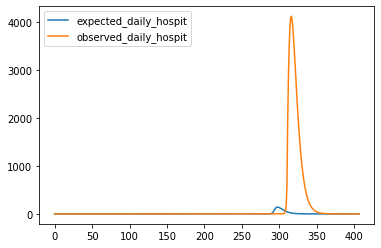


Prior Loss:5550.01318359375  Random Walk Loss:128.957763671875 Comparison Loss:156961.546875 


Time Step: 80 || Loss: 162640.515625 || Learning Rate: 5.221784807558924e-05

R0:4.997921568338428  grad:-126.7748828481345
alpha:0.0004953921929555967  grad:873.3490099135512
phi:49.99999999989285  grad:3.0501747741685876e-07
sigma:0.2013476226332342  grad:0.5817118495708711
epsilon_t.mean:-0.3731057643890381  grad.mean:-783.8704223632812
tau:199.9999999939194  grad:-1.3290061928394543e-07

This Run:  0.4712226390838623 seconds


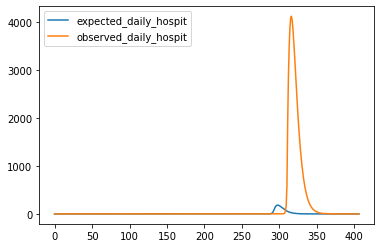


Prior Loss:5552.0498046875  Random Walk Loss:129.19903564453125 Comparison Loss:148482.5 


Time Step: 90 || Loss: 154163.75 || Learning Rate: 4.397794664115188e-05

R0:4.998017287229722  grad:-96.64207120518246
alpha:0.00040055580064531543  grad:-2281.2658680576124
phi:49.99999999989285  grad:3.0213259079089e-07
sigma:0.20132634182859405  grad:0.16513244887178988
epsilon_t.mean:-0.37280428409576416  grad.mean:-633.2944946289062
tau:199.9999999939194  grad:-1.7159355204080858e-08

This Run:  0.49045658111572266 seconds


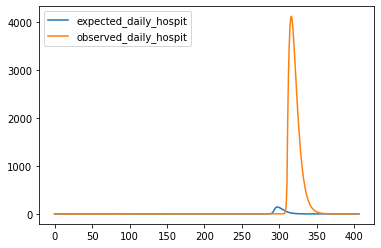

Complete Run:  49.22339391708374 seconds


In [15]:
# Visualization initialization
alpha_vis = []
sigma_vis = []
R0_vis = []
tau_vis = []
phi_vis = []
epsilon_mean_vis = []
loss_vis = []
prior_loss_vis = []
rw_loss_vis = []
comp_loss_vis = []
learning_rate_vis = []

learning_rate = 1e-4
epochs = 100
complete_time = time.time()


for k in range(epochs):
    start_time = time.time()
    decay = (1 - (k / (epochs * 100))) ** 2
    learning_rate = learning_rate * decay

    # forward pass - calculate expected_daily_hospit
    expected_daily_hospit, Rt, ll_prior, ll_rw, ll_comp, tau, R0, phi, alpha, sigma = forward_pass()

    # backward pass
    loss = ll_prior + ll_rw + ll_comp
    loss.backward()

    if k % 10 == 0:
        print(
            f'\nPrior Loss:{ll_prior}  Random Walk Loss:{ll_rw} Comparison Loss:{ll_comp} \n'
            f'\n\nTime Step: {k} || Loss: {loss} || Learning Rate: {learning_rate}\n\nR0:{R0}  grad:{R0_prime.grad}\nalpha:{alpha}  grad:{alpha_prime.grad}\n'
            f'phi:{phi}  grad:{phi_prime.grad}\nsigma:{sigma}  grad:{sigma_prime.grad}'
            f'\nepsilon_t.mean:{epsilon_t.mean()}  grad.mean:{epsilon_t.grad.mean()}\ntau:{tau}  grad:{tau_prime.grad}\n')
        print("This Run:  %s seconds" % (time.time() - start_time))
    

    
    with torch.no_grad():  # this part is SGD. can also replace with loss.step
        tau_prime -= learning_rate * tau_prime.grad
        phi_prime -= learning_rate * phi_prime.grad
        R0_prime -= learning_rate * R0_prime.grad
        alpha_prime -= learning_rate * alpha_prime.grad
        sigma_prime -= learning_rate * sigma_prime.grad
        epsilon_t -= learning_rate * epsilon_t.grad * 0.001

        tau_prime.grad = None
        phi_prime.grad = None
        R0_prime.grad = None
        alpha_prime.grad = None
        sigma_prime.grad = None
        epsilon_t.grad = None


    # Visualization
    alpha_vis.append(alpha)
    sigma_vis.append(sigma)
    R0_vis.append(R0)
    tau_vis.append(tau)
    phi_vis.append(phi)
    epsilon_mean_vis.append(epsilon_t.abs().mean())
    loss_vis.append(loss)
    prior_loss_vis.append(ll_prior)
    rw_loss_vis.append(ll_rw)
    comp_loss_vis.append(ll_comp)
    learning_rate_vis.append(learning_rate)

    if k % 10 == 0:
        plt.plot(expected_daily_hospit.cpu().detach().numpy(), label='expected_daily_hospit')
        plt.plot(observed_daily_hospit.cpu().detach().numpy(), label='observed_daily_hospit')
        plt.legend()
        plt.show()

    if k % 500 == 0:
        fig, axs = plt.subplots(4)
        fig.suptitle(f'Time step {k}')
        axs[0].plot(alpha_vis)
        axs[0].title.set_text('Alpha')
        axs[1].plot(sigma_vis)
        axs[1].title.set_text('Sigma')
        axs[2].plot(R0_vis)
        axs[2].title.set_text('R0')
        axs[3].plot(tau_vis)
        axs[3].title.set_text('Tau')
        fig.tight_layout()
        plt.show()


print("Complete Run:  %s seconds" % (time.time() - complete_time))

# Evaluate Model

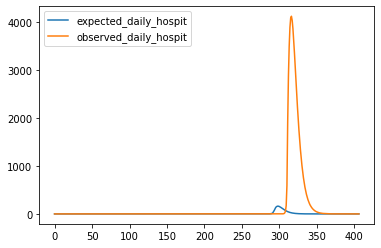

In [16]:
plt.plot(expected_daily_hospit.cpu().detach().numpy(), label='expected_daily_hospit')
plt.plot(observed_daily_hospit.cpu().detach().numpy(), label='observed_daily_hospit')
plt.legend()
plt.show()

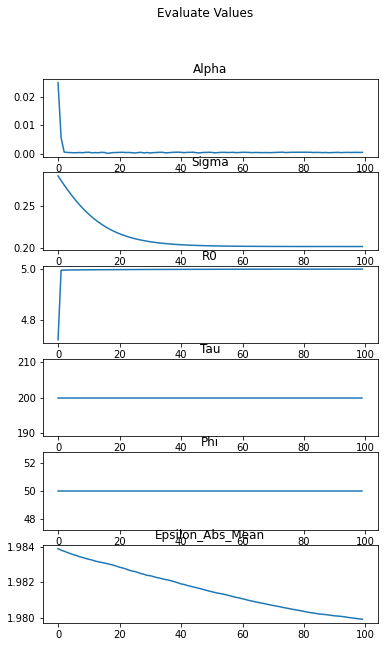

In [17]:
fig, axs = plt.subplots(6)
fig.suptitle(f'Evaluate Values')
fig.set_figheight(10)
axs[0].plot(alpha_vis)
axs[0].title.set_text('Alpha')
axs[1].plot(sigma_vis)
axs[1].title.set_text('Sigma')
axs[2].plot(R0_vis)
axs[2].title.set_text('R0')
axs[3].plot(tau_vis)
axs[3].title.set_text('Tau')
axs[4].plot(phi_vis)
axs[4].title.set_text('Phi')
axs[5].plot(epsilon_mean_vis)
axs[5].title.set_text('Epsilon_Abs_Mean')
plt.show()

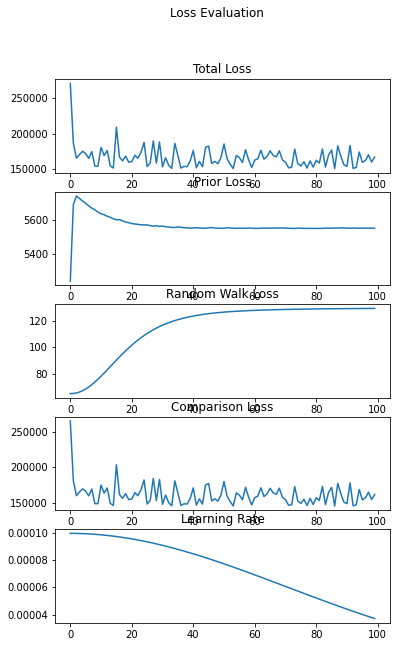

In [18]:
fig, axs = plt.subplots(5)
fig.suptitle(f'Loss Evaluation')
fig.set_figheight(10)
axs[0].plot(loss_vis)
axs[0].title.set_text('Total Loss')
axs[1].plot(prior_loss_vis)
axs[1].title.set_text('Prior Loss')
axs[2].plot(rw_loss_vis)
axs[2].title.set_text('Random Walk Loss')
axs[3].plot(comp_loss_vis)
axs[3].title.set_text('Comparison Loss')
axs[4].plot(learning_rate_vis)
axs[4].title.set_text('Learning Rate')
plt.show()

In [19]:
phi_prime = torch.tensor(1)
phi = bij_transform(phi_prime, lower=1, upper=50)
exp_daily = torch.tensor(20)
obs_daily = torch.tensor(20)
p = 1 / (1 + exp_daily / phi)
dist = torch.distributions.negative_binomial.NegativeBinomial(phi, p)
ll = dist.log_prob(obs_daily)
print(f'phi: {phi}, p: {p}, ll: {ll}')

phi: 36.82187271118164, p: 0.6480228900909424, ll: -12.906089782714844
